# Sign-Language MNIST

In [1]:
# Import Libraries
import numpy as np 
import pandas as pd 
import random

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')

# sklearn
from sklearn.model_selection import train_test_split

#tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPool2D, Input, Dense
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Load Dataset

In [2]:
# Read Dataset
train = pd.read_csv('sign_mnist_train.csv')
test = pd.read_csv('sign_mnist_test.csv')

In [3]:
# show data format
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
#Datasset Shape
train.shape

(27455, 785)

In [5]:
# get labels 
labels = train['label']
print(labels)
print(np.unique(train['label']))

0         3
1         6
2         2
3         2
4        13
         ..
27450    13
27451    23
27452    18
27453    17
27454    23
Name: label, Length: 27455, dtype: int64
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [6]:
# droping the label coloumn from the training set
train.drop('label', axis = 1, inplace = True)
print(train.shape)

(27455, 784)


In [7]:
# Reshape
x_train = train.values.reshape(train.shape[0],28,28,1)

In [8]:
x_train.shape[0]

27455

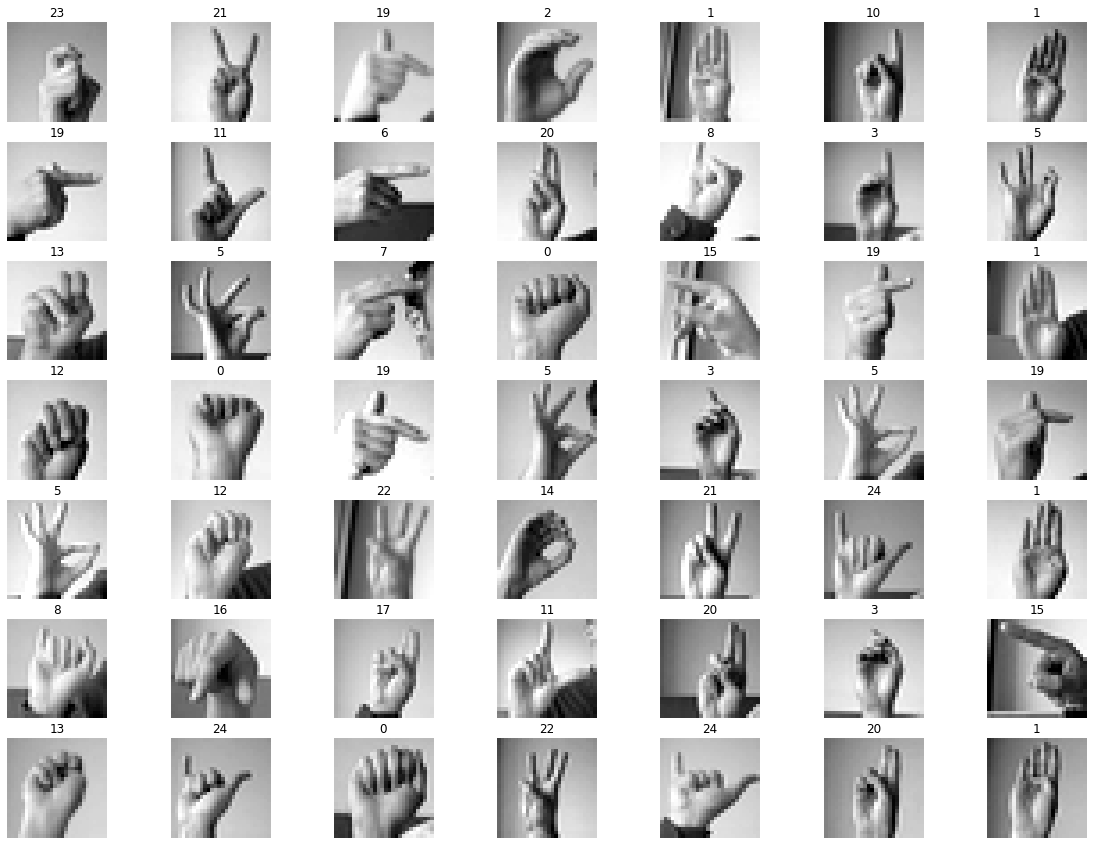

In [9]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(7, 7)
#
for line in range(0, 7):
    for row in range(0, 7):
        num_image = random.randint(0, x_train.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title(labels[num_image])
        ax.imshow(x_train[num_image]);

## Data exploration

<AxesSubplot:xlabel='label', ylabel='count'>

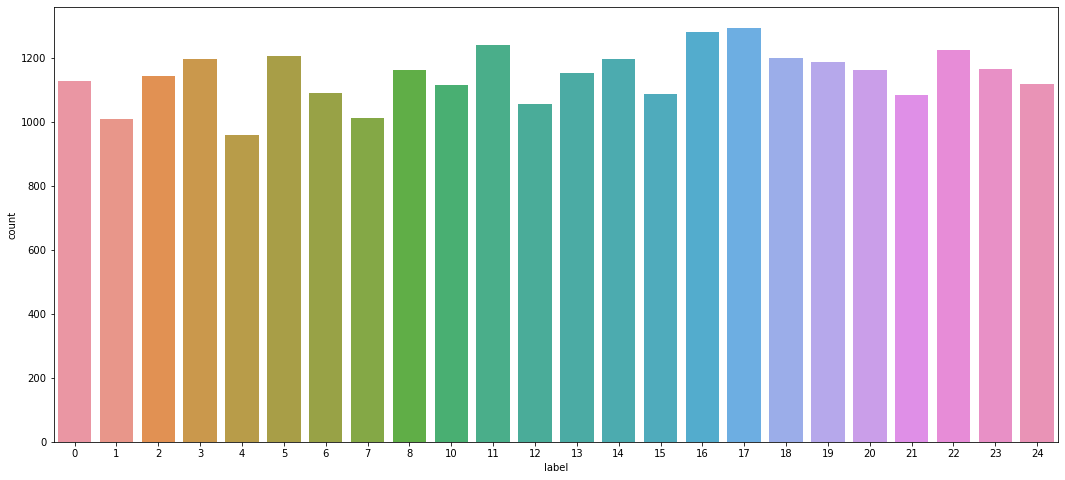

In [10]:
# explore the label distribution of training images
plt.figure(figsize = (18,8))
sns.countplot(x = labels)

*As you can see each one is almost equally distributed !*

In [11]:
# one-hot encoding
labels = to_categorical(labels)
print(labels.shape)

(27455, 25)


## Prepare Data

In [12]:
# Split Dataset into Train and Test
x_train, x_test, y_train, y_test = train_test_split(x_train, labels, test_size = 0.25, random_state = 42, stratify = labels)

In [13]:
# Normalize Dataset
x_train = x_train / 255.0
x_test = x_test / 255.0

In [14]:
print(x_train.shape)
print(x_test.shape)

(20591, 28, 28, 1)
(6864, 28, 28, 1)


## Build CNN model

In [15]:
num_classes = 25
input_shape = (28,28,1)

In [16]:
# Build Model
model = models.Sequential()

model.add(layers.Conv2D(64, kernel_size=(3,3), padding='same', activation = 'swish', input_shape = input_shape ))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2, 2)))

model.add(layers.Conv2D(64, kernel_size = (3, 3), padding='same', activation = 'swish'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2, 2)))

model.add(layers.Conv2D(64, kernel_size = (3, 3), padding='same', activation = 'swish'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_classes, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          3

In [17]:
# Compile Model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

In [18]:
#early stopping
checkpoint = ModelCheckpoint('model/sign_language.h5', monitor = 'val_loss', save_best_only = True,
                             mode = 'min', verbose = 1)
earlystop = EarlyStopping(monitor = 'val_loss', patience = 7, mode = 'min', verbose = 1, restore_best_weights = True,
                          min_delta = 0.001)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.003, patience = 3, verbose = 1, mode = 'min',
                              min_delta = 0.0001)
callback = [checkpoint, reduce_lr, earlystop]

## Train Model

In [19]:
# Train Model
history = model.fit(x_train, y_train,
                    batch_size = 8,
                    epochs=1000,
                    validation_split=0.3,
                    callbacks=[callback])

Epoch 1/1000
1802/1802 [==============================] - 51s 28ms/step - loss: 1.2799 - accuracy: 0.6276 - val_loss: 0.0690 - val_accuracy: 0.9790

Epoch 00001: val_loss improved from inf to 0.06903, saving model to model\sign_language.h5
Epoch 2/1000
1802/1802 [==============================] - 57s 32ms/step - loss: 0.0637 - accuracy: 0.9806 - val_loss: 1.0741 - val_accuracy: 0.7525

Epoch 00002: val_loss did not improve from 0.06903
Epoch 3/1000
1802/1802 [==============================] - 55s 31ms/step - loss: 0.0504 - accuracy: 0.9841 - val_loss: 0.1236 - val_accuracy: 0.9623

Epoch 00003: val_loss did not improve from 0.06903
Epoch 4/1000
1802/1802 [==============================] - 53s 29ms/step - loss: 0.0401 - accuracy: 0.9870 - val_loss: 0.1649 - val_accuracy: 0.9456

Epoch 00004: val_loss did not improve from 0.06903

Epoch 00004: ReduceLROnPlateau reducing learning rate to 3.000000142492354e-06.
Epoch 5/1000
1802/1802 [==============================] - 69s 38ms/step - loss:

## Training History

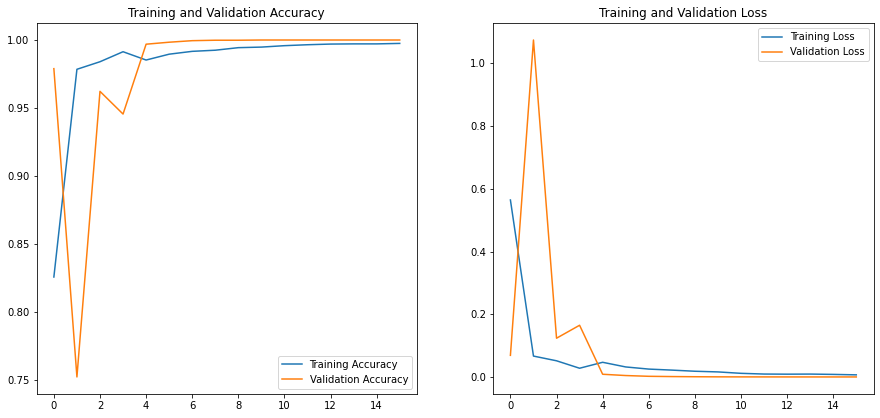

In [20]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs_range = model.history.epoch

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluate Model

In [22]:
# Test Accuracy
score = model.evaluate(x_test, y_test, verbose = 0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.0013797292485833168
Test accuracy:  0.9992715716362
